## Using another approach where the architecture of the network is constant while learning each task. We use the method called "Synaptic Intelligence".

## To unlearn, the weights are set to zero.

#### Get the source code from https://github.com/ganguli-lab/pathint 
Put this jupytper notebook into `fig_split_mnist` folder. Then run.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from pathint import utils
#import seaborn as sns
#sns.set_style("ticks")

from tqdm import trange, tqdm

# import operator
import matplotlib.colors as colors
import matplotlib.cm as cmx

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


## Parameters

In [2]:
select = tf.select if hasattr(tf, 'select') else tf.where

In [3]:
# Data params
input_dim = 784
output_dim = 10

# Network params
n_hidden_units = 50
activation_fn = tf.nn.relu

# Optimization params
batch_size = 1000
epochs_per_task = 5

n_stats = 1

# Reset optimizer after each age
reset_optimizer = True

## Construct datasets

In [4]:
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9], [4,6],[8,1],[0,3],[2,4],[5,7]]
#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9], [4,6],[8,1],[0,3],[2,9],[5,7]]
# task_labels = [[0,1,2,3,4], [5,6,7,8,9]]
n_tasks = len(task_labels)
training_datasets = utils.construct_split_mnist(task_labels, split='train')
validation_datasets = utils.construct_split_mnist(task_labels, split='test')
# training_datasets = utils.mk_training_validation_splits(full_datasets, split_fractions=(0.9, 0.1))

## Construct network, loss, and updates

In [5]:
tf.reset_default_graph()

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

In [7]:
# tf.equal(output_mask[None, :], 1.0)

In [8]:
import keras.backend as K
import keras.activations as activations

output_mask = tf.Variable(tf.zeros(output_dim), name="mask", trainable=False)

def masked_softmax(logits):
    # logits are [batch_size, output_dim]
    x = select(tf.tile(tf.equal(output_mask[None, :], 1.0), [tf.shape(logits)[0], 1]), logits, -1e32 * tf.ones_like(logits))
    return activations.softmax(x)

def set_active_outputs(labels):
    new_mask = np.zeros(output_dim)
    for l in labels:
        new_mask[l] = 1.0
    sess.run(output_mask.assign(new_mask))
    #print(sess.run(output_mask))
    
def masked_predict(model, data, targets):
    pred = model.predict(data)
    #print(pred)
    acc = np.argmax(pred,1)==np.argmax(targets,1)
    return acc.mean()

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
from keras.models import Sequential
from keras.layers import Dense

from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
def custom_activation(x):
    A=K.relu(x)
    return(K.log(1+A))
get_custom_objects().update({'custom_activation':Activation(custom_activation)})

model = Sequential()
model.add(Dense(n_hidden_units, activation=activation_fn, input_shape=(input_dim,)))
#model.add(Dense(n_hidden_units, activation=activation_fn))
model.add(Dense(output_dim, kernel_initializer='zero', activation=masked_softmax))
#model.add(Dense(output_dim, activation=masked_softmax, input_shape=(input_dim,)))

In [10]:
from pathint import protocols
from pathint.optimizers import KOOptimizer
from keras.optimizers import Adam, RMSprop,SGD
from keras.callbacks import Callback
from pathint.keras_utils import LossHistory
from keras.callbacks import History 
from keras.callbacks import LambdaCallback

#protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
#protocol_name, protocol = protocols.FISHER_PROTOCOL('sum')
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
# opt = SGD(1e-3)
# opt = RMSprop(lr=1e-3)
oopt = KOOptimizer(opt, model=model, compute_fisher=False, **protocol)
model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])
model.model._make_train_function()
saved_weights = model.get_weights()

save_weights_epoch=[]
save_loss_epoch=[]
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: save_weights_epoch.append(model.get_weights()))
history = LossHistory()
callbacks = [history]
datafile_name = "split_mnist_data_%s.pkl.gz"%protocol_name

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


## Train!

In [11]:
import pdb
def run_fits(cvals, training_data, valid_data, eval_on_train_set=False, nstats=1):
    acc_mean = dict()
    acc_std = dict()
    model_weights_save = []   #Empty list to save the model weights aftertraining each task
    for cidx, cval_ in enumerate(tqdm(cvals)):
        runs = []
        for runid in range(nstats):
            sess.run(tf.global_variables_initializer())
            # model.set_weights(saved_weights)
            cstuffs = []
            evals = []
            print("setting cval")
            cval = cval_
            oopt.set_strength(cval)
            oopt.init_task_vars()
            print("cval is", sess.run(oopt.lam))
            for age, tidx in enumerate(range(n_tasks)):
                print("Task %i"%(age))
                set_active_outputs(task_labels[age])
                stuffs = model.fit(training_data[tidx][0], training_data[tidx][1], batch_size, epochs_per_task, callbacks=[history,print_weights], verbose=0)
                oopt.update_task_metrics(training_data[tidx][0], training_data[tidx][1], batch_size)
                oopt.update_task_vars()
                ftask = []
                model_weights_save.append(model.get_weights()) #Save the model weights aftertraining each task
                for j in range(n_tasks):
                    set_active_outputs(task_labels[j])
                    if eval_on_train_set:
                        f_ = masked_predict(model, training_data[j][0], training_data[j][1])
                    else:
                        f_ = masked_predict(model, valid_data[j][0], valid_data[j][1])
                    ftask.append(np.mean(f_))
                print("Accuracy", ftask)
                evals.append(ftask)
                cstuffs.append(stuffs)

                # Re-initialize optimizater variables
                if reset_optimizer:
                    oopt.reset_optimizer()

            evals = np.array(evals)
            runs.append(evals)
        
        runs = np.array(runs)
        acc_mean[cval_] = runs.mean(0)
        acc_std[cval_] = runs.std(0)
    return dict(mean=acc_mean, std=acc_std),model_weights_save,cstuffs

In [12]:
# cvals = np.concatenate(([0], np.logspace(-2, 2, 10)))
# cvals = np.concatenate(([0], np.logspace(-1, 2, 2)))
# cvals = np.concatenate(([0], np.logspace(-2, 0, 3)))
cvals = np.logspace(-3, 3, 7)#[0, 1.0, 2, 5, 10]
cvals = [1.0]
print(cvals)

[1.0]


In [13]:
#%%capture
recompute_data = True
if recompute_data:
    data,model_weights_save,cstuffs = run_fits(cvals, training_datasets, validation_datasets, eval_on_train_set=False, nstats=n_stats)
    utils.save_zipped_pickle(data, datafile_name)
    
for task_id in range(len(task_labels)):
    set_active_outputs(task_labels[task_id])    
    print('Task ', {task_id}, ' accuracy: ', masked_predict(model, validation_datasets[task_id][0], validation_datasets[task_id][1]))        

  0%|          | 0/1 [00:00<?, ?it/s]

setting cval
cval is 1.0
Task 0
Accuracy [0.9995271867612293, 0.5053868756121449, 0.5240128068303095, 0.4823766364551863, 0.49117498739283916]
Task 1
Accuracy [0.9995271867612293, 0.9711067580803134, 0.5240128068303095, 0.4823766364551863, 0.49117498739283916]
Task 2
Accuracy [0.9990543735224586, 0.9118511263467189, 0.9765208110992529, 0.4823766364551863, 0.49117498739283916]
Task 3
Accuracy [0.9990543735224586, 0.9128305582761999, 0.9727854855923159, 0.9914400805639476, 0.49117498739283916]
Task 4


100%|██████████| 1/1 [00:04<00:00,  4.67s/it]

Accuracy [0.9990543735224586, 0.9098922624877571, 0.9802561366061899, 0.9919436052366566, 0.9626828038325769]
Task  {0}  accuracy:  0.9990543735224586
Task  {1}  accuracy:  0.9098922624877571
Task  {2}  accuracy:  0.9802561366061899


Task  {3}  accuracy:  0.9919436052366566
Task  {4}  accuracy:  0.9626828038325769


In [20]:
def lower_triangular(matrix):
    rows, cols = matrix.shape
    result = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            if j <= i:
                result[i][j] = matrix[i][j]
    return result

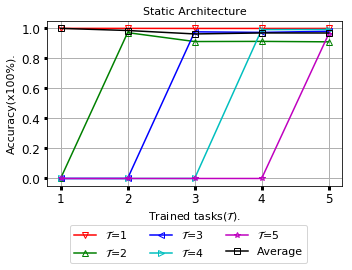

In [32]:
import pdb
figure(figsize=(5, 4))
axs = [subplot(1,1,1)]#, None, None]
fontsize = 11

keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

colorVal = ['r','g','b','c','m','k','y','tomato']
marker=["v","^","<",">","*","s","h","x","."]
cval=1
mean_stuff=[]
std_stuff=[]
for i in range(len(data['mean'][cval])):
    data['mean'][cval] = lower_triangular(data['mean'][cval])
    mean_stuff.append(data['mean'][cval][i][:i+1].mean())
    std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        label = "$\mathcal{T}$=%g"%(j+1)
        axs[0].plot(range(1,n_tasks+1), mean_vals[:, j], marker=marker[j], c=colorVal[j], fillstyle='none', label=label)
    axs[0].plot(range(1,n_tasks+1), mean_stuff, marker=marker[j+1], c=colorVal[j+1],fillstyle='none', label='Average')
    axs[0].legend(loc='upper right',prop={'size': fontsize}, bbox_to_anchor=(0.90, -0.2), ncol=3)
    axs[0].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
    axs[0].set_ylabel('Accuracy(x100%).',fontsize=fontsize)
    axs[0].set_xticks(range(1,n_tasks+1))
    axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axs[0].tick_params(labelsize='large', width=3)
    axs[0].set_title('Static Architecture', fontsize=fontsize)
#plt.legend(bbox_to_anchor=(0.78, 0.66),bbox_transform=plt.gcf().transFigure)
gcf().tight_layout()
plt.grid(linestyle='-', linewidth=1)
plt.savefig('MNIST_SI.pdf',bbox_inches = "tight")

#### Sparsity checks before unlearning

In [33]:
# Function to calculate sparsity
def calculate_sparsity(model):
    total_weights = 0
    zero_weights = 0
    for layer in model.layers:
        if isinstance(layer, Dense):
            weights = layer.get_weights()
            if weights:
                for weight in weights:
                    total_weights += np.prod(weight.shape)
                    zero_weights += np.sum(weight == 0)
    return zero_weights / total_weights

print('Sparsity of the model before unlearning:', calculate_sparsity(model))

Sparsity of the model before unlearning: 0.0


#### Unlearning task 2 containing labels [4,5]. Please note that the task numbering starts from 0.

Zeroing only output layer weights.

In [34]:
#Accuracy aftering forgetting one of the task
#Assume that task 1 is forgetted.

forget_task=2
class_to_forget = task_labels[forget_task]
#Zero out the weights corresponding to this class
for task_id in range(len(task_labels)):
    set_active_outputs(task_labels[task_id])
    
    for k,layer in enumerate(model.layers):  # Exclude output layer
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            if layer == model.layers[-1]:
                for cl in class_to_forget:
                    weights[:, cl] = 0  # Zero out weights for the forgotten class in the output layer
                    biases[cl] = 0
            layer.set_weights([weights, biases])
    
    print('Task ', {task_id}, ' accuracy: ', masked_predict(model, validation_datasets[task_id][0], validation_datasets[task_id][1]))        

Task  {0}  accuracy:  0.9990543735224586
Task  {1}  accuracy:  0.9098922624877571
Task  {2}  accuracy:  0.5240128068303095
Task  {3}  accuracy:  0.9919436052366566
Task  {4}  accuracy:  0.9626828038325769


That shows the forgetting for task 1 as its accuracy is close to 50%. Other tasks accuracy is unimpacted. 

#### Sparsity checks after unlearning

In [35]:
print('Sparsity of the model after unlearning (zeoring output payer weights only):', calculate_sparsity(model))

Sparsity of the model after unlearning (zeoring output payer weights only): 0.0025653923541247483


In [36]:
#Inspection of behavior of importance parameter big_omega after every task 
from numpy import count_nonzero
last_epoch_batchindex = []
counter = 0
for i,j in enumerate(history.batchindex):
    try:
        if history.batchindex[i+1] > j:
            pass
        else:
            counter = counter+1
            if counter%epochs_per_task == 0:
                last_epoch_batchindex.append(i)
    except:
        last_epoch_batchindex.append(i)
        
# Define a function to extract the variable name
def extract_variable_name(variable):
    return variable.name

print('Batch-id for last epoch of each task:',last_epoch_batchindex)
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    keys = list(history.big_omega[epoch_id].keys())
    # Sort the list based on variable names
    key = sorted(keys, key=extract_variable_name)
    print('Parameter importance (big_omega) for task {0} shape is '.format(i), [history.big_omega[epoch_id][ke].shape for ke in key]) 

non_zero_imp_param = []
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    keys = list(history.big_omega[epoch_id].keys())
    # Sort the list based on variable names
    key = sorted(keys, key=extract_variable_name)
    non_zero_imp_param.append(sum([count_nonzero(history.big_omega[epoch_id][ke]) for ke in key]))
    print('Number of non-zero elements of importance (big_omega) for task {0} is '.format(i),non_zero_imp_param[i])

Batch-id for last epoch of each task: [64, 129, 189, 254, 314]
*----------------------------*
Parameter importance (big_omega) for task 0 shape is  [(50,), (784, 50), (10,), (50, 10)]
Parameter importance (big_omega) for task 1 shape is  [(50,), (784, 50), (10,), (50, 10)]
Parameter importance (big_omega) for task 2 shape is  [(50,), (784, 50), (10,), (50, 10)]
Parameter importance (big_omega) for task 3 shape is  [(50,), (784, 50), (10,), (50, 10)]
Parameter importance (big_omega) for task 4 shape is  [(50,), (784, 50), (10,), (50, 10)]
*----------------------------*
Number of non-zero elements of importance (big_omega) for task 0 is  0
Number of non-zero elements of importance (big_omega) for task 1 is  30320
Number of non-zero elements of importance (big_omega) for task 2 is  33444
Number of non-zero elements of importance (big_omega) for task 3 is  34277
Number of non-zero elements of importance (big_omega) for task 4 is  36007


#### Further zeroing weights based on the importance of weight (Big Omega :  $\Omega_k^\mu$).

In [37]:
import numpy as np

def find_zero_indices(array):
    zero_indices = []
    if isinstance(array, np.ndarray):
        zero_indices = np.argwhere(array == 0).tolist()
    else:
        if isinstance(array, (list, tuple)):
            for i in range(len(array)):
                if isinstance(array[i], (list, tuple)):
                    for j in range(len(array[i])):
                        if array[i][j] == 0:
                            zero_indices.append((i, j))
                else:
                    if array[i] == 0:
                        zero_indices.append((i,))
    return zero_indices

In [38]:
Importance_collect= {}
for i,epoch_id in enumerate(last_epoch_batchindex):
    keys = list(history.big_omega[epoch_id].keys())
    # Sort the list based on variable names
    key = sorted(keys, key=extract_variable_name)
    Importance_collect[i] = [history.big_omega[epoch_id][ke] for ke in key]
    
print(key)

weight_indices_zero = {}
for i in range(1,len(last_epoch_batchindex)): #after frist task
    weight_indices_zero[i] = []
    for j in range(len(Importance_collect[i])):
        weight_indices_zero[i].append(find_zero_indices(Importance_collect[i][j]))

[<tf.Variable 'dense_1/bias:0' shape=(50,) dtype=float32_ref>, <tf.Variable 'dense_1/kernel:0' shape=(784, 50) dtype=float32_ref>, <tf.Variable 'dense_2/bias:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'dense_2/kernel:0' shape=(50, 10) dtype=float32_ref>]


#### Zeroing weights based on zero value of $\Omega^\mu_k$ after learning forget_task.

In [46]:
#Accuracy aftering forgetting one of the task
#Assume that task 1 is forgetted.
acc_log = []
forget_task=2
class_to_forget = task_labels[forget_task]
#Zero out the weights corresponding to this class
for task_id in range(len(task_labels)):
    set_active_outputs(task_labels[task_id])
    
    for k,layer in enumerate(model.layers):  # Exclude output layer
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            if layer == model.layers[-1]:
                for cl in class_to_forget:
                    weights[:, cl] = 0  # Zero out weights for the forgotten class in the output layer
                    biases[cl] = 0
            else:
                for iids in weight_indices_zero[forget_task][k]: #for biases, look at the key printing in the above cell
                    biases[iids[0]] = 0
                for iids in weight_indices_zero[forget_task][k+1]: #for weights, look at the key printing in the above cell
                    weights[iids[0],iids[1]]= 0
                    
            layer.set_weights([weights, biases])
    curr_acc = masked_predict(model, validation_datasets[task_id][0], validation_datasets[task_id][1])
    acc_log.append(curr_acc)
    print('Task ', {task_id}, ' accuracy: ', curr_acc)        

Task  {0}  accuracy:  0.9990543735224586
Task  {1}  accuracy:  0.9094025465230167
Task  {2}  accuracy:  0.5240128068303095
Task  {3}  accuracy:  0.9919436052366566
Task  {4}  accuracy:  0.9626828038325769


#### Sparsity after dropping unimportant parameters after forget task.

In [40]:
print('Sparsity of the model after complete forgetting:', calculate_sparsity(model))

Sparsity of the model after complete forgetting: 0.15372233400402416


#### Zeroing the weights that are most important for forget task.

In [49]:
#Assume that task 2 is forgetted.
forget_task=2
forget_task_only_indices = []
for i in range(len(weight_indices_zero[forget_task])):
    # Convert the nested lists to tuples to make them hashable
    set1 = set(tuple(inner_list) for inner_list in weight_indices_zero[forget_task][i])
    set2 = set(tuple(inner_list) for inner_list in weight_indices_zero[forget_task-1][i])
    
    # Find the set difference
    difference = set2 - set1
    # Convert the tuples back to lists
    result = [list(inner_tuple) for inner_tuple in difference]
    
    forget_task_only_indices.append(result)
    
#Accuracy aftering forgetting one of the task
class_to_forget = task_labels[forget_task]
acc_log = []
#Zero out the weights corresponding to this class
for task_id in range(len(task_labels)):
    set_active_outputs(task_labels[task_id])
    
    for k,layer in enumerate(model.layers):  # Exclude output layer
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            if layer == model.layers[-1]:
                for cl in class_to_forget:
                    weights[:, cl] = 0  # Zero out weights for the forgotten class in the output layer
                    biases[cl] = 0
            else:
                try:
                    for iids in forget_task_only_indices[k]: #for biases, look at the key printing in the above cell
                        biases[iids[0]] = 0
                    for iids in forget_task_only_indices[k+1]: #for weights, look at the key printing in the above cell
                        weights[iids[0],iids[1]]= 0
                except:
                    pdb.set_trace()
                    
            layer.set_weights([weights, biases])
    
    curr_acc = masked_predict(model, validation_datasets[task_id][0], validation_datasets[task_id][1])
    acc_log.append(curr_acc)
    print('Task ', {task_id}, ' accuracy: ', curr_acc)        

Task  {0}  accuracy:  0.9990543735224586
Task  {1}  accuracy:  0.9094025465230167
Task  {2}  accuracy:  0.5240128068303095
Task  {3}  accuracy:  0.9919436052366566
Task  {4}  accuracy:  0.9626828038325769


In [61]:
def lower_triangular_array(lst):
    n = len(lst)
    result = [[0] * n for _ in range(n)]  # Initialize an n x n matrix with zeros
    for i in range(n):
        for j in range(i + 1):
            result[i][j] = lst[j]  # Assign elements from the list to the lower triangular part
    return result

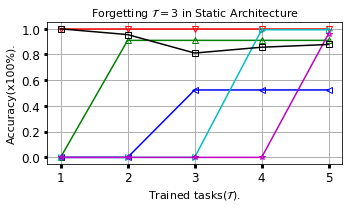

In [66]:
import pdb
figure(figsize=(5, 3))
axs = [subplot(1,1,1)]#, None, None]
fontsize = 11

keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

colorVal = ['r','g','b','c','m','k','y','tomato']
marker=["v","^","<",">","*","s","h","x","."]
cval=1
mean_stuff=[]
std_stuff=[]
data['mean'][cval] = np.array(lower_triangular_array(acc_log))
for i in range(len(data['mean'][cval])):
    data['mean'][cval] = lower_triangular(data['mean'][cval])
    mean_stuff.append(data['mean'][cval][i][:i+1].mean())
    std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        label = "$\mathcal{T}$=%g"%(j+1)
        axs[0].plot(range(1,n_tasks+1), mean_vals[:, j], marker=marker[j], c=colorVal[j], fillstyle='none', label=label)
    axs[0].plot(range(1,n_tasks+1), mean_stuff, marker=marker[j+1], c=colorVal[j+1],fillstyle='none', label='Average')
    #axs[0].legend(loc='upper right',prop={'size': fontsize}, bbox_to_anchor=(0.90, -0.2), ncol=3)
    axs[0].set_xlabel("Trained tasks($\mathcal{T}$).",fontsize=fontsize)
    axs[0].set_ylabel('Accuracy(x100%).',fontsize=fontsize)
    axs[0].set_xticks(range(1,n_tasks+1))
    axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axs[0].tick_params(labelsize='large', width=3)
    axs[0].set_title('Forgetting $\mathcal{T}=3$ in Static Architecture', fontsize=fontsize)
#plt.legend(bbox_to_anchor=(0.78, 0.66),bbox_transform=plt.gcf().transFigure)
gcf().tight_layout()
plt.grid(linestyle='-', linewidth=1)
plt.savefig('MNIST_SI_forgetting_T3.pdf',bbox_inches = "tight")

#### Sparsity checks after complete unlearning

In [42]:
print('Sparsity of the model after complete forgetting:', calculate_sparsity(model))

Sparsity of the model after complete forgetting: 0.22972837022132797


#### Inspecting loss.

In [43]:
#Inspection of losses after every task 
loss_after_task=[]
print('Batch-id for last epoch of each task:',last_epoch_batchindex)
print('*----------------------------*')
for i,epoch_id in enumerate(last_epoch_batchindex):
    loss_after_task.append(history.losses[epoch_id])
    print('Loss after task {0} '.format(i), history.losses[epoch_id]) 
print('*----------------------------*')

#Inspection of surrogate loss or regularization (sum(big_omega x (theta'-theta))) after every task 
surrogate_loss_after_task=[]
for i,epoch_id in enumerate(last_epoch_batchindex):
    surrogate_loss_after_task.append(history.regs[epoch_id])
    print('Surrogate loss after task {0} '.format(i), history.regs[epoch_id]) 

Batch-id for last epoch of each task: [64, 129, 189, 254, 314]
*----------------------------*
Loss after task 0  0.022217404
Loss after task 1  0.10922473
Loss after task 2  0.093091235
Loss after task 3  0.05212844
Loss after task 4  0.10583387
*----------------------------*
Surrogate loss after task 0  0.0
Surrogate loss after task 1  0.035240445
Surrogate loss after task 2  0.058651082
Surrogate loss after task 3  0.034089155
Surrogate loss after task 4  0.025541563


In [44]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
None
